In [5]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U --pre torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/nightly/cu113
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 75.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 100.6 MB/s eta 0:00:00
  ERROR: HTTP error 403 while getting https://download.pytorch.org/whl/nightly/nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (from https://download.pytorch.org/whl/nightly/cu113/nvidia-cuda-nvrtc-cu12/)
ERROR: Could not install requirement nvidia-cuda-nvrtc-cu12==12.1.105 from https://download.pytorch.org/whl/nightly/nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (from torch) because of HTTP error 403 Client Error: Forbidden for url: https://download.pytorch.org/whl/nightly/nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl for URL http

In [8]:
 import matplotlib.pyplot as plt
 import torch
 import torchvision

 from torch import nn
 from torchvision import transforms

try:
    from torchinfo import summary
except:
    !pip install -q torchinfo
    from torchinfo import summary

try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves



[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Total 4056 (delta 0), reused 0 (delta 0), pack-reused 4056
Receiving objects: 100% (4056/4056), 646.90 MiB | 33.27 MiB/s, done.
Resolving deltas: 100% (2371/2371), done.
Updating files: 100% (248/248), done.


In [9]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [10]:

# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"


In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cuda'

# Preprocess Data

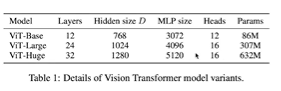

In [16]:
# turn images into tensors
IMG_SIZE = 224

manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.ToTensor(),
])

print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [17]:
BATCH_SIZE = 32

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7e1ec3c9ebf0>,
 ['pizza', 'steak', 'sushi'])

In [18]:
image_batch, label_batch = next(iter(train_dataloader))
image, label = image_batch[0], label_batch[0]
image.shape, label

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


(torch.Size([3, 224, 224]), tensor(2))

PyTorch torch.permute() rearranges the original tensor according to the desired ordering and returns a new multidimensional rotated tensor. The size of the returned tensor remains the same as that of the original.


```
image.permute(1,2,0)
```
 [color_channels, height, width] -> [height, width, color_channels]


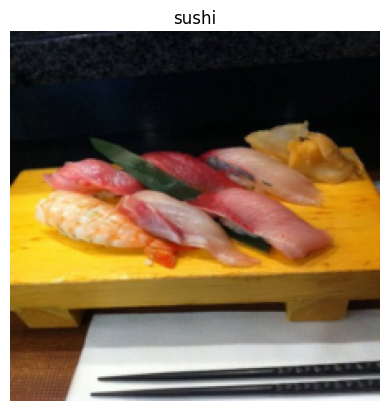

In [13]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

# 1. Replicate the ViT architecture
We need:
1. PatchEmbedding (turn images into embedded patches)
2. Transformer Encoder layer (this is comprised of alternating MSA and MLP blocks)
3. Stack multiple transformer encoder layers on top of each other
4. MLP head
5. Put it all together

### 1. Make patchembedding layer

In [14]:
rand_image_tensor = torch.randn(32,3,224,224)#batch size, color channel, height, width
rand_image_tensor.shape

torch.Size([32, 3, 224, 224])

In [15]:
# create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
    """
    Turns a 2D input image into a 1D sequence learnable embedding vector.

    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """
    # init the class with appropriate variables
    def __init__(self,
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()
        self.patch_size = patch_size
        # create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)
        # create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2,end_dim=3) # only flatten the feature map dimensions into a single vector
    # define the forward method
    def forward(self, x):
        # create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % self.patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"

        # perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        # make sure the output shape has the right order
        return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]

In [16]:
patch_embedding = PatchEmbedding(patch_size=16)
patch_embedding_output = patch_embedding(rand_image_tensor)
print(f"Input shape: {rand_image_tensor.shape}")
print(f"Output shape: {patch_embedding_output.shape} -> (batch_size, num_patches, embedding_dim)")


Input shape: torch.Size([32, 3, 224, 224])
Output shape: torch.Size([32, 196, 768]) -> (batch_size, num_patches, embedding_dim)


In [17]:
224*224*3,196*768

(150528, 150528)

## 2. Transformer encoder layer

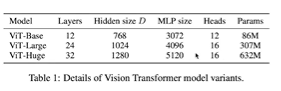

In [18]:
transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768,
                                                       nhead=12,
                                                       dim_feedforward=3072,
                                                       dropout=0.1,
                                                       activation="gelu",
                                                       batch_first=True,
                                                       norm_first=True)
transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [19]:
from torchinfo import summary

summary(model=transformer_encoder_layer,
        input_size=patch_embedding_output.shape)

Layer (type:depth-idx)                   Output Shape              Param #
TransformerEncoderLayer                  [32, 196, 768]            7,087,872
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 19.27
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 19.27

## 3. Stack Transformer ENcoder Layers to make the full Transformer Encoder

According to Table 1 of the ViT paper, the ViT-Base model uses a stack of 12 Transformer Encoder layers.

In [20]:
transformer_encoder = nn.TransformerEncoder(
    encoder_layer=transformer_encoder_layer,
    num_layers=12
)

transformer_encoder

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


TransformerEncoder(
  (layers): ModuleList(
    (0-11): 12 x TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
      )
      (linear1): Linear(in_features=768, out_features=3072, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=3072, out_features=768, bias=True)
      (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
  )
)

In [21]:
summary(model=transformer_encoder,
         input_size=patch_embedding_output.shape)

Layer (type:depth-idx)                   Output Shape              Param #
TransformerEncoder                       [32, 196, 768]            --
├─ModuleList: 1-1                        --                        --
│    └─TransformerEncoderLayer: 2-1      [32, 196, 768]            7,087,872
│    └─TransformerEncoderLayer: 2-2      [32, 196, 768]            7,087,872
│    └─TransformerEncoderLayer: 2-3      [32, 196, 768]            7,087,872
│    └─TransformerEncoderLayer: 2-4      [32, 196, 768]            7,087,872
│    └─TransformerEncoderLayer: 2-5      [32, 196, 768]            7,087,872
│    └─TransformerEncoderLayer: 2-6      [32, 196, 768]            7,087,872
│    └─TransformerEncoderLayer: 2-7      [32, 196, 768]            7,087,872
│    └─TransformerEncoderLayer: 2-8      [32, 196, 768]            7,087,872
│    └─TransformerEncoderLayer: 2-9      [32, 196, 768]            7,087,872
│    └─TransformerEncoderLayer: 2-10     [32, 196, 768]            7,087,872
│    └─Transfor

## 5. Put it all together
We're skipping step 4, so that can be incorported the into the overall ViT architecture.

In [22]:
class ViT(nn.Module):
    def __init__(self,
                 img_size=224,#from table3, training resolution
                 num_channels=3,
                 patch_size=16,
                 embedding_dim=768,#table1
                 dropout=0.1,
                 mlp_size=3072,#table1
                 num_transformer_layers=12,#table1
                 num_heads=12,#table1
                 num_classes=1000):
        super().__init__()

        #Assert image size is divisible by patch size
        assert img_size % patch_size == 0, "Image size must be divisible by patch size"

        # 1 create patch embedding
        self.patch_embedding = PatchEmbedding(in_channels=num_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)
        # 2 create class token
        self.class_token = nn.Parameter(torch.randn(1, 1, embedding_dim),
                                        requires_grad=True)
        # 3 create positional embedding
        num_patches = (img_size*img_size) // patch_size**2 # N=HW/P^2
        self.positional_embedding = nn.Parameter(torch.randn(1, num_patches+1, embedding_dim))
        # 4 create patch + position embedding dropout
        self.embedding_dropout = nn.Dropout(p=dropout)
        # 5 create transformes encoder layer (single)
        # self.transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim,
        #                                                             nhead=num_heads,
        #                                                             dim_feedforward=mlp_size,
        #                                                             activation="gelu",
        #                                                             batch_first=True,
        #                                                             norm_first=True)
        # 5 create transformes encoder layer
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer=nn.TransformerEncoderLayer(d_model=embedding_dim,
                                                                                                    nhead=num_heads,
                                                                                                    dim_feedforward=mlp_size,
                                                                                                    activation="gelu",
                                                                                                    batch_first=True,
                                                                                                    norm_first=True),
                                                                                        num_layers=num_transformer_layers)

        # 6 create mlp head
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )
    def forward(self, x):
        #get some dimensions
        batch_size=x.shape[0]
        #patch embed
        x=self.patch_embedding(x)

        #we need a class token per image in our batch so expand the class token across the batch size
        class_token = self.class_token.expand(batch_size,-1,-1)
        #prepend the class token to the patch embedding
        x = torch.cat((class_token,x),dim=1)
        # add the pos embed to patch embed with class token
        x=self.positional_embedding+x
        #dropout on patch+pos embed
        x = self.embedding_dropout(x)
        #pass embed thwough transformer encoder stack
        x = self.transformer_encoder(x)
        # pass just 0zt index(class token) of x through MLP head
        x = self.mlp_head(x[:,0])
        return x



In [23]:
demo_img = torch.randn(1,3,224,224)
print(demo_img.shape)
vit = ViT(num_classes=len(class_names))
vit(demo_img)

torch.Size([1, 3, 224, 224])


tensor([[ 0.3855,  0.3967, -0.2353]], grad_fn=<AddmmBackward0>)

In [24]:
summary(model=vit,
        input_size=demo_img.shape)

Layer (type:depth-idx)                        Output Shape              Param #
ViT                                           [1, 3]                    152,064
├─PatchEmbedding: 1-1                         [1, 196, 768]             --
│    └─Conv2d: 2-1                            [1, 768, 14, 14]          590,592
│    └─Flatten: 2-2                           [1, 768, 196]             --
├─Dropout: 1-2                                [1, 197, 768]             --
├─TransformerEncoder: 1-3                     [1, 197, 768]             --
│    └─ModuleList: 2-3                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-2      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-3      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-4      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-5      [1, 197, 76

In [25]:
embedding_dim = 768
class_token = nn.Parameter(torch.randn(1, 1, embedding_dim),
                           requires_grad=True)
class_token.requires_grad

True

In [26]:
batch_size = 32
print(class_token.shape)
class_token.expand(batch_size, -1,-1).shape #-1 means to infer the dimension


torch.Size([1, 1, 768])


torch.Size([32, 1, 768])

In [27]:
num_patches = (224*224)//16**2
pos_embedding=nn.Parameter(torch.randn(1, num_patches+1, embedding_dim))
pos_embedding.shape

torch.Size([1, 197, 768])

# Turn the custom Vit architecture to a python script: vit.py

In [1]:
%%writefile vit.py
import torch
from torch import nn
# create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
    """
    Turns a 2D input image into a 1D sequence learnable embedding vector.

    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """
    # init the class with appropriate variables
    def __init__(self,
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()
        self.patch_size = patch_size
        # create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)
        # create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2,end_dim=3) # only flatten the feature map dimensions into a single vector
    # define the forward method
    def forward(self, x):
        # create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % self.patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"

        # perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        # make sure the output shape has the right order
        return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]

class ViT(nn.Module):
    def __init__(self,
                 img_size=224,#from table3, training resolution
                 num_channels=3,
                 patch_size=16,
                 embedding_dim=768,#table1
                 dropout=0.1,
                 mlp_size=3072,#table1
                 num_transformer_layers=12,#table1
                 num_heads=12,#table1
                 num_classes=1000):
        super().__init__()

        #Assert image size is divisible by patch size
        assert img_size % patch_size == 0, "Image size must be divisible by patch size"

        # 1 create patch embedding
        self.patch_embedding = PatchEmbedding(in_channels=num_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)
        # 2 create class token
        self.class_token = nn.Parameter(torch.randn(1, 1, embedding_dim),
                                        requires_grad=True)
        # 3 create positional embedding
        num_patches = (img_size*img_size) // patch_size**2 # N=HW/P^2
        self.positional_embedding = nn.Parameter(torch.randn(1, num_patches+1, embedding_dim))
        # 4 create patch + position embedding dropout
        self.embedding_dropout = nn.Dropout(p=dropout)
        # 5 create transformes encoder layer (single)
        # self.transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim,
        #                                                             nhead=num_heads,
        #                                                             dim_feedforward=mlp_size,
        #                                                             activation="gelu",
        #                                                             batch_first=True,
        #                                                             norm_first=True)
        # 5 create transformes encoder layer
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer=nn.TransformerEncoderLayer(d_model=embedding_dim,
                                                                                                    nhead=num_heads,
                                                                                                    dim_feedforward=mlp_size,
                                                                                                    activation="gelu",
                                                                                                    batch_first=True,
                                                                                                    norm_first=True),
                                                                                        num_layers=num_transformer_layers)

        # 6 create mlp head
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )
    def forward(self, x):
        #get some dimensions
        batch_size=x.shape[0]
        #patch embed
        x=self.patch_embedding(x)

        #we need a class token per image in our batch so expand the class token across the batch size
        class_token = self.class_token.expand(batch_size,-1,-1)
        #prepend the class token to the patch embedding
        x = torch.cat((class_token,x),dim=1)
        # add the pos embed to patch embed with class token
        x=self.positional_embedding+x
        #dropout on patch+pos embed
        x = self.embedding_dropout(x)
        #pass embed thwough transformer encoder stack
        x = self.transformer_encoder(x)
        # pass just 0zt index(class token) of x through MLP head
        x = self.mlp_head(x[:,0])
        return x



Writing vit.py


In [2]:
!python vit.py

In [6]:
from vit import ViT
#from vit import PatchEmbedding
imported_vit = ViT()
summary(model=imported_vit,input_size=(1,3,224,224))

Layer (type:depth-idx)                        Output Shape              Param #
ViT                                           [1, 1000]                 152,064
├─PatchEmbedding: 1-1                         [1, 196, 768]             --
│    └─Conv2d: 2-1                            [1, 768, 14, 14]          590,592
│    └─Flatten: 2-2                           [1, 768, 196]             --
├─Dropout: 1-2                                [1, 197, 768]             --
├─TransformerEncoder: 1-3                     [1, 197, 768]             --
│    └─ModuleList: 2-3                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-2      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-3      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-4      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-5      [1, 197, 76

# Train a pretrained ViT feature extractor model on %20 data

In [13]:
import random


In [14]:
set_seeds()

In [20]:
import torchvision

vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
pretrained_vit = torchvision.models.vit_b_16(weights=vit_weights)
for param in pretrained_vit.parameters():
    param.requires_grad=False

embedding_dim = 768 #vitbase
set_seeds()
pretrained_vit.heads = nn.Sequential(
    nn.LayerNorm(normalized_shape=embedding_dim),
    nn.Linear(in_features=embedding_dim,out_features=len(class_names))
)

summary(model=pretrained_vit,
        input_size=(1,3,224,224),
        col_names=["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=["var_names"])


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

In [23]:
# Get 20% of the data
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

# Setup train and test directories
train_dir_20_percent = data_20_percent_path / "train"
# test_dir_20_percent = data_20_percent_path / "test" # don't need 20% test data as the model in 07. PyTorch Experiment Tracking section 7.3 tests on the 10% dataset not the 20%

# Preprocess the data
vit_transforms = vit_weights.transforms() # get transforms from vit_weights
train_dataloader_20_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                                          test_dir=test_dir, # use 10% data for testing
                                                                                          transform=vit_transforms,
                                                                                          batch_size=1024)

[INFO] data/pizza_steak_sushi_20_percent directory exists, skipping download.


In [24]:
len(train_dataloader), len(train_dataloader_20_percent), len(test_dataloader)

(8, 1, 1)

In [26]:
from going_modular.going_modular import engine

optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_20_percent,
                                      test_dataloader=test_dataloader,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 1 | train_loss: 1.2156 | train_acc: 0.2333 | test_loss: 1.0258 | test_acc: 0.4933
Epoch: 2 | train_loss: 0.9635 | train_acc: 0.5222 | test_loss: 0.8168 | test_acc: 0.6267
Epoch: 3 | train_loss: 0.7688 | train_acc: 0.7267 | test_loss: 0.6602 | test_acc: 0.7067
Epoch: 4 | train_loss: 0.6219 | train_acc: 0.8178 | test_loss: 0.5427 | test_acc: 0.8000
Epoch: 5 | train_loss: 0.5116 | train_acc: 0.8711 | test_loss: 0.4539 | test_acc: 0.8800
Epoch: 6 | train_loss: 0.4290 | train_acc: 0.8889 | test_loss: 0.3868 | test_acc: 0.8933
Epoch: 7 | train_loss: 0.3669 | train_acc: 0.9089 | test_loss: 0.3359 | test_acc: 0.9067
Epoch: 8 | train_loss: 0.3201 | train_acc: 0.9133 | test_loss: 0.2973 | test_acc: 0.9067
Epoch: 9 | train_loss: 0.2843 | train_acc: 0.9178 | test_loss: 0.2679 | test_acc: 0.9200
Epoch: 10 | train_loss: 0.2566 | train_acc: 0.9244 | test_loss: 0.2454 | test_acc: 0.9333


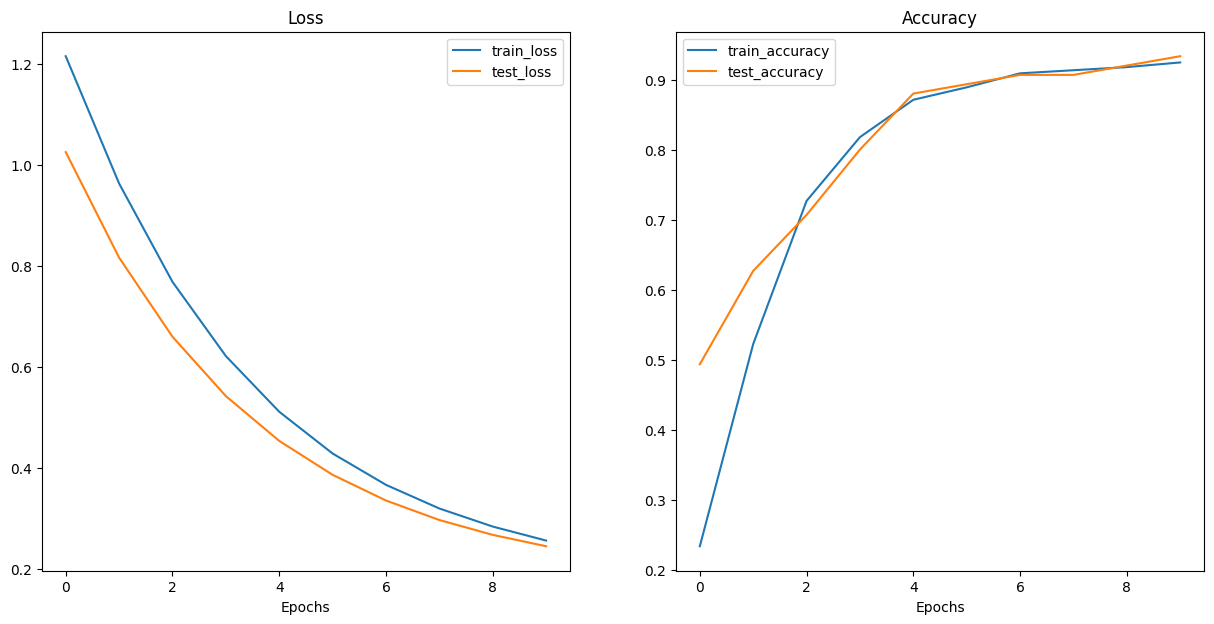

In [27]:
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)